In [1]:
# !pip install pandas gspread oauth2client

In [2]:
import json
import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials

JSON Fields:

- Solution Text: This contains the actual solution submitted by the student. For programming tasks, it could be the source code.
- Email: The email address of the student who submitted the solution.
- Submission Datetime: The timestamp when the submission was made.
- Course ID: The ID of the course to which the task belongs. This allows us to separate submissions by course.
- User ID: A unique identifier for the user making the submission.
- Visibility: This indicates the visibility status of the submission (e.g., "UNPUBLISHED").
- Task Name: The name of the task being solved (e.g., "Create an Empty Array").
- Status: The result of the submission, indicating whether the submission is correct or wrong.
- ID: A unique identifier for the submission itself.
- Task Type: The type of task (e.g., "edu", "theory"). This can help distinguish between different types of tasks.
- Task ID: A unique identifier for the task being solved.

In [3]:
# Task 1: Parse the file and load data into a pandas DataFrame
def load_submission_data(file_path):
    # Load the JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Create a DataFrame from the list of submissions
    df = pd.DataFrame(data)
    return df


In [4]:
def col_num_to_excel_col_letter(n):
    """Convert column number to Excel-style column letter."""
    letter = ''
    while n > 0:
        n, remainder = divmod(n-1, 26)
        letter = chr(65 + remainder) + letter
    return letter


In [5]:
col_num_to_excel_col_letter(72)

'BT'

In [6]:
from datetime import datetime

# Task 2: Update Google Spreadsheet by Course ID in separate tabs, add new lines and columns if necessary
def update_google_sheet_incremental(df, credentials_file, sheet_name):
    # Authenticate Google Sheets API using the service account credentials
    scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name(credentials_file, scope)
    client = gspread.authorize(creds)
    
    # Open the Google Spreadsheet by name
    spreadsheet = client.open(sheet_name)
    
    # Get unique Course IDs to separate submissions
    course_ids = df['Course ID'].unique()

    # Filter non 'edu' submissions
    df = df[df['Task Type'] == 'edu']
    # Filter late submissions
    df['Submission Datetime'] = pd.to_datetime(df['Submission Datetime'])  # Ensure correct datetime format
    df = df[df['Submission Datetime'] < datetime(2024, 10, 9)]

    for course_id in course_ids:
        # Filter submissions for the current Course ID
        course_df = df[df['Course ID'] == course_id]
        
        # Get unique emails (students) and task names (tasks)
        emails = course_df['Email'].unique()
        task_names = course_df['Task Name'].unique()
        print(len(task_names), task_names)
        
        # Sheet title for the current course
        sheet_title = f"Course {course_id}"
        
        # Check if the worksheet for this course already exists
        try:
            worksheet = spreadsheet.worksheet(sheet_title)
        except gspread.exceptions.WorksheetNotFound:
            # Create a new worksheet for the course if it doesn't exist
            worksheet = spreadsheet.add_worksheet(title=sheet_title, rows=1000, cols=100)
            worksheet.append_row(['Email'] + list(task_names))  # Add headers if a new worksheet is created
            existing_emails = []
            existing_headers = ['Email'] + list(task_names)
        else:
            # Get existing data from the sheet (including headers)
            existing_data = worksheet.get_all_values()
            existing_headers = existing_data[0] if existing_data else ['Email']  # First row
            existing_emails = [row[0] for row in existing_data[1:]]  # First column, skip header
        
        # Add new task columns if not already present
        for task_name in task_names:
            if task_name not in existing_headers:
                existing_headers.append(task_name)
        
        # Prepare the batch update list for rows (using A1 notation)
        updates = []

        # Update or add student results for each submission
        for email in emails:
            if email in existing_emails:
                # Find the row for the existing student
                row_idx = existing_emails.index(email) + 2  # Add 2 for 1-based indexing and to account for header row
            else:
                # New student, add a new row
                row_idx = len(existing_emails) + 2
                worksheet.append_row([email] + [0] * (len(existing_headers) - 1))
                existing_emails.append(email)
            
            # For each task submission, update if the status is correct
            for _, row in course_df[course_df['Email'] == email].iterrows():
                if row['Status'] == 'correct':
                    col_idx = existing_headers.index(row['Task Name']) + 1  # Add 1 to skip email column
                    column_letter = col_num_to_excel_col_letter(col_idx)
                    updates.append({
                                'range': f'{column_letter}{row_idx}',
                                'values': [[1]]
                            })
        # If there are any updates to make, execute them in a batch
        if updates:
            print(updates)
            worksheet.batch_update(updates)

    print("Data incrementally updated successfully for all courses.")


In [7]:
# Main script execution
submission_file = './data/query_result_2024-10-14T08_45_42.381571Z.json'
credentials_file = './data/aiclub-435409-2881eaca101a.json'
sheet_name = 'AI club gradebook'
    
# Load the submissions into a DataFrame
df = load_submission_data(submission_file)
    
# Update Google Sheet with the processed data
update_google_sheet_incremental(df, credentials_file, sheet_name)

/var/folders/r8/1llvc8sx345f0h_dnn8z50ph0000gp/T/ipykernel_27809/3277972286.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Submission Datetime'] = pd.to_datetime(df['Submission Datetime'])  # Ensure correct datetime format


2 ['Create an Empty Array' 'Create an Array from List']
[{'range': 'B2', 'values': [[1]]}, {'range': 'C2', 'values': [[1]]}]
74 ['Comments' 'Comparison operators' 'Boolean operators' 'Assignments'
 'Arithmetic operators' 'Type conversion' 'Variable types'
 'Undefined variable' 'Variable definition' 'String negative indexing'
 'String indexing' 'String multiplication' 'Concatenation' 'Indentation'
 'Single-line if-else statement' 'Else and elif parts in if statement'
 'If statement' 'Boolean operators order' 'In keyword' 'Dictionary keys'
 'Dictionary keys() and values()' 'Add Items from lists' 'Dictionaries'
 'String formatting' 'Join method' 'Tuples' 'Nested Lists' 'List items'
 'Lists operations' 'Lists introduction' 'F-strings'
 'Basic string methods' 'Character escaping' 'String length' 'In operator'
 'String slicing' 'Nested List Comprehension' 'Fix infinite execution'
 'Recursion' 'Default parameters' 'Args and kwargs' 'Argument Order'
 'Keyword Arguments' 'Docstrings' 'Return va

/var/folders/r8/1llvc8sx345f0h_dnn8z50ph0000gp/T/ipykernel_27809/1330630741.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  course_df['Submission Datetime'] = pd.to_datetime(course_df['Submission Datetime'])


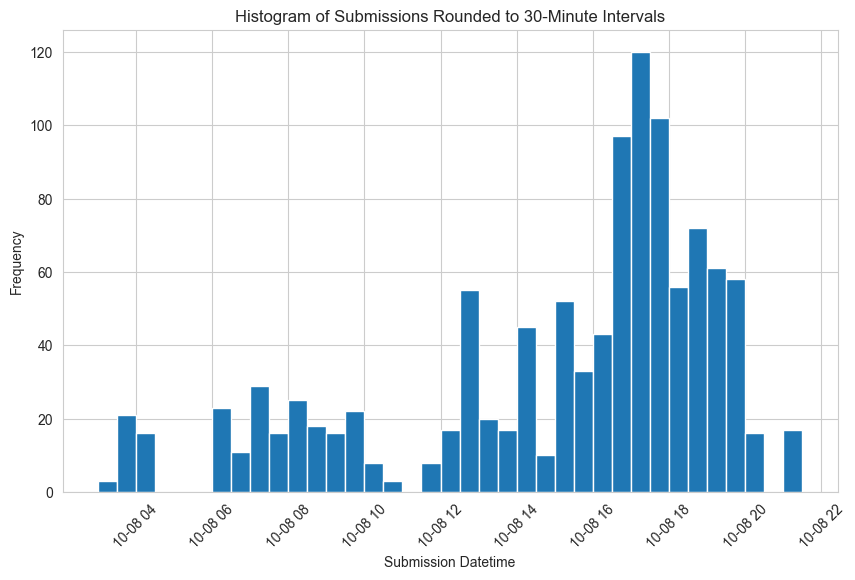

In [8]:
from matplotlib import pyplot as plt

course_df = df[df['Course ID'] == 16630]
# Convert 'Submission Datetime' to datetime objects
course_df['Submission Datetime'] = pd.to_datetime(course_df['Submission Datetime'])

course_df = course_df[course_df['Submission Datetime'] > datetime(2024, 10, 7)]
course_df = course_df[course_df['Submission Datetime'] < datetime(2024, 10, 9)]

# Round to the nearest 30 minutes
course_df['Rounded Submission Datetime'] = course_df['Submission Datetime'].dt.round('30min')

# Plot the histogram with 30-minute bins
plt.figure(figsize=(10, 6))
course_df['Rounded Submission Datetime'].hist(bins=pd.date_range(start=course_df['Rounded Submission Datetime'].min(),
                                                                 end=course_df['Rounded Submission Datetime'].max(),
                                                                 freq='30min'))
plt.xlabel('Submission Datetime')
plt.ylabel('Frequency')
plt.title('Histogram of Submissions Rounded to 30-Minute Intervals')
plt.xticks(rotation=45)
plt.show()


/var/folders/r8/1llvc8sx345f0h_dnn8z50ph0000gp/T/ipykernel_27809/196124082.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  course_df['Submission Datetime'] = pd.to_datetime(course_df['Submission Datetime'])


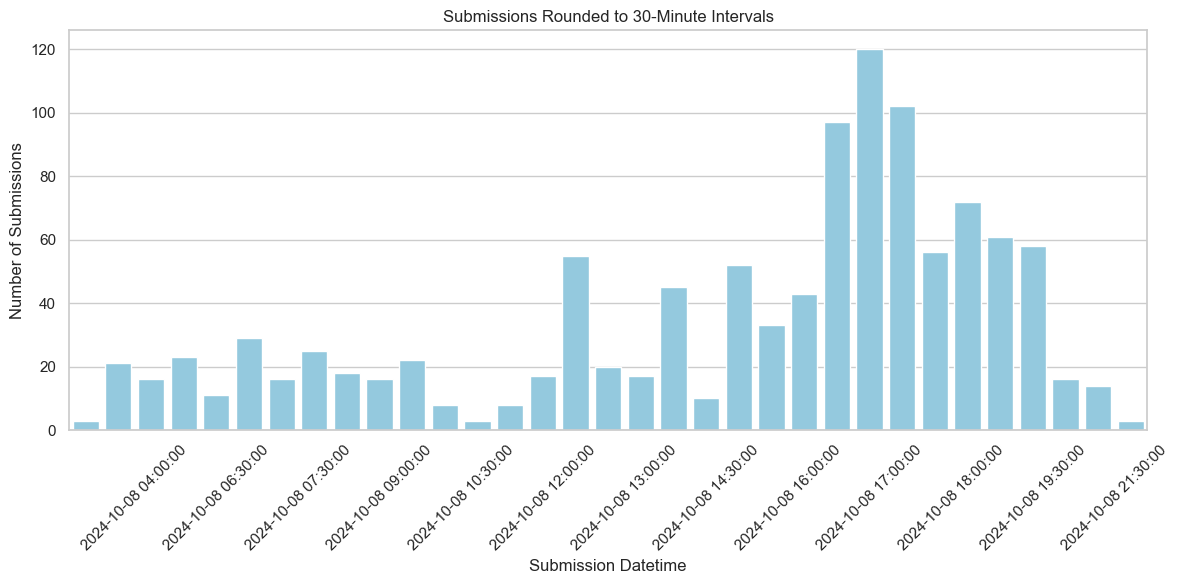

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Filter the DataFrame for the specific course ID
course_df = df[df['Course ID'] == 16630]

# Convert 'Submission Datetime' to datetime objects
course_df['Submission Datetime'] = pd.to_datetime(course_df['Submission Datetime'])

# Filter the date range
course_df = course_df[(course_df['Submission Datetime'] > pd.to_datetime('2024-10-07')) &
                      (course_df['Submission Datetime'] < pd.to_datetime('2024-10-09'))]

# Round to the nearest 30 minutes
course_df['Rounded Submission Datetime'] = course_df['Submission Datetime'].dt.round('30min')

# Get submission counts per 30-minute interval
submission_counts = course_df.groupby('Rounded Submission Datetime').size().reset_index(name='Frequency')

# Set Seaborn style
sns.set(style='whitegrid')

# Create the plot
plt.figure(figsize=(12, 6))

# Plot using Seaborn barplot
sns.barplot(
    data=submission_counts,
    x='Rounded Submission Datetime',
    y='Frequency',
    color='skyblue'
)

# Format the x-axis for better readability
ax = plt.gca()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=60))  # Set major ticks every hour

plt.xlabel('Submission Datetime')
plt.ylabel('Number of Submissions')
plt.title('Submissions Rounded to 30-Minute Intervals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
